In [1]:
import numpy as np
import matplotlib.pyplot as plt

Declare the file paths

In [ ]:
sunflowerPath = "../Video Overlay Exercise/YUVs/720p25_sunflower.yuv"
logoPath = "../Video Overlay Exercise/YUVs/Ittiam_160x100_P420_8b.yuv"

Function to read one single Y frame, U frame and V frame

In [3]:
def read_yuv420p_frame(file, width, height):
    y_size = width * height
    uv_size = (width // 2) * (height // 2)

    y = np.frombuffer(file.read(y_size), dtype = np.uint8)
    u = np.frombuffer(file.read(uv_size), dtype = np.uint8)
    v = np.frombuffer(file.read(uv_size), dtype = np.uint8)

    if y.size < y_size or u.size < uv_size or v.size < uv_size:
        return None

    y = y.reshape((height, width))
    u = u.reshape((height // 2, width // 2))
    v = v.reshape((height // 2, width // 2))

    return y, u, v

### The function overlay_naive() will paste the foreground frame without any mask
### The function overlay_text() masks some part of the foreground frame.

In [4]:
def overlay_naive(background_frame, foreground_frame, pos_i, pos_j):
    h, w = foreground_frame.shape
    H, W = background_frame.shape

    newframe = background_frame.copy()
    if pos_i + h < H and pos_j + w < W:
        newframe[pos_i:pos_i+h, pos_j:pos_j+w] = foreground_frame
    elif pos_i + h >= H and pos_j + w < W:
        i_cut = H - pos_i
        newframe[pos_i : pos_i + i_cut, pos_j : pos_j + w] = foreground_frame[0 : i_cut, :]
        newframe[0 : h - i_cut, pos_j : pos_j + w] = foreground_frame[i_cut : , :]
    elif pos_i + h < H and pos_j + w >= W:
        j_cut = W - pos_j
        newframe[pos_i : pos_i + h, pos_j : pos_j + j_cut] = foreground_frame[:, 0 : j_cut]
        if pos_i + 2*h < H:
            newframe[pos_i + h: pos_i + 2*h, 0 : w - j_cut] = foreground_frame[:, j_cut :]
        else:
            i_cut = H - pos_i - h
            newframe[pos_i + h: , 0 : w - j_cut] = foreground_frame[: i_cut, j_cut :]
            newframe[0 : h - i_cut, 0 : w - j_cut] = foreground_frame[i_cut : , j_cut : ]
    elif pos_i + h >= H and pos_j + w >= W:
        i_cut = H - pos_i
        j_cut = W - pos_j
        newframe[pos_i : pos_i + i_cut, pos_j : pos_j + j_cut] = foreground_frame[0 : i_cut, 0 : j_cut] # 1
        newframe[h - i_cut : 2 * h - i_cut, 0 : w - j_cut] = foreground_frame[:, j_cut :] # 2 and 4
        newframe[0 : h - i_cut, pos_j : pos_j + j_cut] = foreground_frame[i_cut : , 0 : j_cut] # 3
    
    return newframe

def overlay_text(background_frame, foreground_frame, pos_i, pos_j, mask):
    h, w = foreground_frame.shape
    H, W = background_frame.shape

    newframe = background_frame.copy()
    if pos_i + h < H and pos_j + w < W:
        newframe[pos_i:pos_i+h, pos_j:pos_j+w] = foreground_frame * mask + background_frame[pos_i:pos_i+h, pos_j:pos_j+w] * (1 - mask)
    elif pos_i + h >= H and pos_j + w < W:
        i_cut = H - pos_i
        newframe[pos_i : pos_i + i_cut, pos_j : pos_j + w] = foreground_frame[0 : i_cut, :] * mask[0 : i_cut, :] + background_frame[pos_i : pos_i + i_cut, pos_j : pos_j + w] * (1 - mask[0 : i_cut, :])
        newframe[0 : h - i_cut, pos_j : pos_j + w] = foreground_frame[i_cut : , :] * mask[i_cut : , :] + background_frame[0 : h - i_cut, pos_j : pos_j + w] * (1 - mask[i_cut : , :])
    elif pos_i + h < H and pos_j + w >= W:
        j_cut = W - pos_j
        newframe[pos_i : pos_i + h, pos_j : pos_j + j_cut] = foreground_frame[:, 0 : j_cut] * mask[:, 0 : j_cut] + background_frame[pos_i : pos_i + h, pos_j : pos_j + j_cut] * (1 - mask[:, 0 : j_cut])
        if pos_i + 2*h < H:
            newframe[pos_i + h: pos_i + 2*h, 0 : w - j_cut] = foreground_frame[:, j_cut :] * mask[:, j_cut :] + background_frame[pos_i + h: pos_i + 2*h, 0 : w - j_cut] * (1 - mask[:, j_cut :])
        else:
            i_cut = H - pos_i - h
            newframe[pos_i + h: , 0 : w - j_cut] = foreground_frame[: i_cut, j_cut :] * mask[: i_cut, j_cut :] + background_frame[pos_i + h: , 0 : w - j_cut] * (1 - mask[: i_cut, j_cut :])
            newframe[0 : h - i_cut, 0 : w - j_cut] = foreground_frame[i_cut : , j_cut :] * mask[i_cut : , j_cut :] + background_frame[0 : h - i_cut, 0 : w - j_cut] * (1 - mask[i_cut : , j_cut :])
    elif pos_i + h >= H and pos_j + w >= W:
        i_cut = H - pos_i
        j_cut = W - pos_j
        newframe[pos_i : pos_i + i_cut, pos_j : pos_j + j_cut] = foreground_frame[0 : i_cut, 0 : j_cut] * mask[0 : i_cut, 0 : j_cut] + background_frame[pos_i : pos_i + i_cut, pos_j : pos_j + j_cut] * (1 - mask[0 : i_cut, 0 : j_cut]) # 1
        newframe[h - i_cut : 2 * h - i_cut, 0 : w - j_cut] = foreground_frame[:, j_cut :] * mask[:, j_cut :] + background_frame[h - i_cut : 2 * h - i_cut, 0 : w - j_cut] * (1 - mask[:, j_cut :])
        newframe[0 : h - i_cut, pos_j : pos_j + j_cut] = foreground_frame[i_cut : , 0 : j_cut] * mask[i_cut : , 0 : j_cut] + background_frame[0 : h - i_cut, pos_j : pos_j + j_cut] * (1 - mask[i_cut : , 0 : j_cut])
        # newframe[0 : h - i_cut, 0 : w - j_cut] = foreground_frame[i_cut : , j_cut : ] * mask[i_cut : , j_cut : ] + background_frame[0 : h - i_cut, 0 : w - j_cut] * (1 - mask[i_cut : , j_cut : ])
    
    return newframe

Function to get the Y, U and V frames of both background and foreground file

In [5]:
def extractFrames(sunflowerPath, logoPath, Sunflower_Height, Sunflower_Width, Logo_Height, Logo_Width):
    Logo_frames = []
    Sunflower_frames = []
    with open(logoPath, 'rb') as logoFile:
        triplet = read_yuv420p_frame(file=logoFile, width=Logo_Width, height=Logo_Height)
        if triplet is not None:
            Logo_frames.append(triplet)
    with open(sunflowerPath, 'rb') as sunflowerFile:
        triplet = read_yuv420p_frame(sunflowerFile, width=Sunflower_Width, height=Sunflower_Height)
        while(triplet is not None):
            Sunflower_frames.append(triplet)
            triplet = read_yuv420p_frame(sunflowerFile, width=Sunflower_Width, height=Sunflower_Height)
    
    return Sunflower_frames, Logo_frames

In [9]:
def overlay_image_on_video(Sunflower_Path, Sunflower_Height, Sunflower_Width, Logo_Path, Logo_Height, Logo_Width, i_stride, j_stride):

    Sunflower_frames, Logo_frames = extractFrames(Sunflower_Path, Logo_Path, Sunflower_Height, Sunflower_Width, Logo_Height, Logo_Width)
    num_frames = len(Sunflower_frames)
    logo_Y, logo_U, _ = Logo_frames[0]
    mask_Y = 1 - np.ones_like(logo_Y) * (logo_Y >= 225)
    mask_UV = 1 - np.ones_like(logo_U) * (logo_U >= 113)

    Y_Frames = []
    U_Frames = []
    V_Frames = []

    H, W = Sunflower_Height, Sunflower_Width
    h, w = Logo_Height, Logo_Width

    i = 0
    j = 0
    for f in range(num_frames):
        # print(f"f = {f}, i = {i}, j = {j}")
        new_y = overlay_text(background_frame=Sunflower_frames[f][0], foreground_frame=Logo_frames[0][0], pos_i=i, pos_j=j, mask=mask_Y)
        new_u = overlay_text(background_frame=Sunflower_frames[f][1], foreground_frame=Logo_frames[0][1], pos_i=i//2, pos_j=j//2, mask=mask_UV)
        new_v = overlay_text(background_frame=Sunflower_frames[f][2], foreground_frame=Logo_frames[0][2], pos_i=i//2, pos_j=j//2, mask=mask_UV)
        Y_Frames.append(new_y)
        U_Frames.append(new_u)
        V_Frames.append(new_v)
        j += j_stride
        i += i_stride
        if j >= W:
            j = j - W
            i += Logo_frames[0][0].shape[0]
        if i >= H:
            i = i - H
    return Y_Frames, U_Frames, V_Frames

In [ ]:
Y_Frames, U_Frames, V_Frames = overlay_image_on_video(sunflowerPath, 720, 1280, logoPath, 100, 160, i_stride=5, j_stride=5)

filename = "../Video Overlay Exercise/move.yuv"
with open(filename, 'wb') as f:
    for y, u, v in zip(Y_Frames, U_Frames, V_Frames):
        f.write(y.tobytes())
        f.write(u.tobytes())
        f.write(v.tobytes())

# Rough

In [146]:
Sunflower_frames, Logo_frames = extractFrames(sunflowerPath, logoPath, 720, 1280, 100, 160)
logo_Y, logo_U, logo_V = Logo_frames[0]
mask_Y = np.ones_like(logo_Y) * (logo_Y >= 225)
mask_UV = np.ones_like(logo_U) * (logo_U >= 113)

In [ ]:
new_y = overlay_text(background_frame=Sunflower_frames[31][0], foreground_frame=Logo_frames[0][0], pos_i=620, pos_j=155, mask=mask_Y)


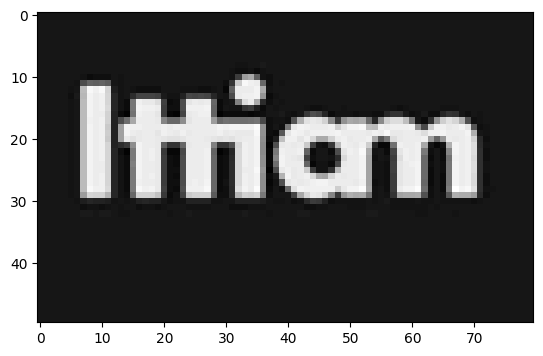

128


In [135]:
plt.imshow(logo_V, cmap='gray')
plt.show()
print(logo_V[0][0])

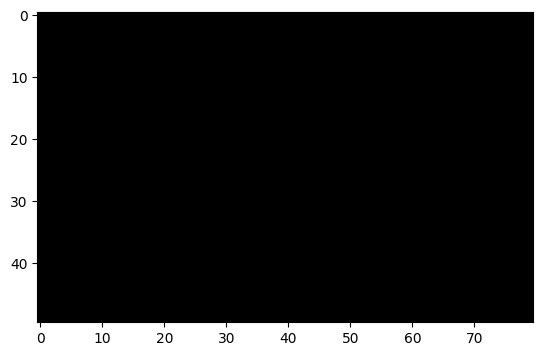

In [134]:
mask_V = np.ones_like(logo_V) * (logo_V <= 113)
plt.imshow(mask_V, cmap='gray')
plt.show()